### GAIA optimiation DBSCAN with MCMC scheme

1. using a simple ABC scheme
2. We updte the conditions on min_cl > min_nei 

In [9]:
using PyCall
using Distributions
using Statistics , StatsBase

using Distances
using Random

push!(LOAD_PATH,"/home/stephane/Science/cluster/GAIA/master/src")
using GaiaClustering

import PyPlot


## directory
rootdir = "/home/stephane/Science/cluster/GAIA"
wdir    = "/home/stephane/Science/cluster/GAIA/products"
plotdir = "/home/stephane/Science/cluster/GAIA/products/test"

cd(wdir)

In [10]:
function getdata(filevot)
    voname = filevot

    data       = read_votable(voname)
    df         = filter_data(data)
    dfcart     = add_cartesian(df)
    blck       = [[1,2,3],[4,5], [6,7,8]]
    wghtblck   = [4.0,5.0,1.0]
    norm       = "identity"

    dfcartnorm , scale8 = normalization_PerBlock(dfcart, blck, wghtblck , norm, false) 
    return(dfcartnorm , dfcart)
end

getdata (generic function with 1 method)

In [11]:
function _theta(p::GaiaClustering.abc)
    peps         = TruncatedNormal(p.epsmean, p.epsdisp, 0.1 , 1000)
    pminnei      = TruncatedNormal(p.min_nei, p.ncoredisp, 1 , 1000.)
    pmincl      = TruncatedNormal(p.min_cl, p.ncoredisp, 1 , 1000.)
    
    e = rand(peps)          ; pe = pdf(peps,e)
    n = trunc(Int,rand(pminnei))  ; pn = pdf(pminnei, n)
    c = trunc(Int,rand(pmincl))   ; pc = pdf(pmincl, c)
    
    ptotal = pe*pn*pc
    params = GaiaClustering.model(e, n, c)
    return(params, ptotal)
end


## iterate with random walk and yield the probability
##
function _thetaiter(θi::GaiaClustering.model , p::GaiaClustering.abc)
    let   
        peps         = TruncatedNormal(p.epsmean, p.epsdisp, 0.1 , 1000)
        pminnei      = TruncatedNormal(p.min_nei, p.ncoredisp, 1 , 1000.)
        pmincl       = TruncatedNormal(p.min_cl, p.ncoredisp, 1 , 1000.)
        
        eps_rw    = TruncatedNormal(θi.eps,0.5 , 0.1, 1000.)
        minnei_rw = TruncatedNormal(θi.min_nei , 4  , 1,  1000.)
        mincl_rw  = TruncatedNormal(θi.min_cl  , 4  , 1, 1000.)
        
        new_e = 0.
        new_mn = 0
        new_mcl = 0
        
        iternotfound =true
        while iternotfound
            new_e = rand(eps_rw)
            new_mn =  trunc(Int,rand(minnei_rw))      
            new_mcl = trunc(Int,rand(mincl_rw))      
        
            if new_e > 0 && new_mn > 0 && new_mcl > 0
                iternotfound = false
            end
        end
    
        pe = pdf(peps , new_e)
        pn = pdf(pminnei, new_mn)
        pc = pdf(pmincl, new_mcl)
        ptotal = pe * pn * pc
    
        params = GaiaClustering.model(new_e, new_mn, new_mcl)
        return(params, ptotal)
    end
end   

#### function to adapt the minimum condition to evaluate the  solution
###
function check_qminqstar(df::GaiaClustering.Df, dfcart::GaiaClustering.Df,
        params::GaiaClustering.abc, minimumQ, minstars)
    let
        new_minq = minimumQ
        new_minstars = minstars
        notfound = true
        mingoodsolution = 10   ## !!!! Check out!!!!
        
        println("### Checking the minQ and minStars conditions...")
        while notfound
            goodsolutions = 0
            for i in 1:params.nburnout
                mi, probi = _theta(params)
                qres , nstars = find_clusters(df, dfcart, mi)
                if qres > new_minq && nstars >= new_minstars
                    goodsolutions += 1
                end
                if goodsolutions > mingoodsolution
                    notfound = false
                end
            end
            if notfound 
                new_minq *= 0.9
                new_minstars = trunc(Int, 0.9 * new_minstars)
            end
            
            if new_minstars == 0
                println("### Problem with minStars, return(0.5,5)")
                return(0.5,5)
            end      
        end
        return(new_minq, new_minstars)
    end
end

## ABC MCMC (following Weyan et al. 2013)
## first simple scheme for testing
##
function _abc_mcmc_dbscan(df::GaiaClustering.Df, dfcart::GaiaClustering.Df, params::GaiaClustering.abc)
    let 
        println("## LOCAL !!ABC/MCMC for DBSCAN...")
        mci = GaiaClustering.mc(zeros(Float64,0),zeros(Int32,0),zeros(Int32,0) , zeros(Float64,0), zeros(Int32,0))
        
        initial = true
        th = []
        mi = GaiaClustering.model(0.0,0,0)
        micurrent = GaiaClustering.model(0.0,0,0)
        probi = 0.
        probcurrent = 0.
    
        minimumQ = params.minQ
        minstars = params.minstars
        niter = params.niter
        nburn = params.nburnout
    
        println("### Minimum Q : $minimumQ")
        println("### Minimum nstars : $minstars")
        minimumQ , minstars = check_qminqstar(df, dfcart, params, minimumQ, minstars)
        #params.minQ = minimuQ
        #params.minstars = minstars
        println("### Minimum Q : $minimumQ")
        println("### Minimum nstars : $minstars")
        
        while initial
            mi, probi = _theta(params)
            qres , nstars = find_clusters(df, dfcart, mi)
            if qres > minimumQ && nstars >= minstars 
                println("### init done ...")
                initial = false
                push!(mci.eps, mi.eps)
                push!(mci.mne, mi.min_nei)
                push!(mci.mcl, mi.min_cl)
                push!(mci.qc,  qres)
                push!(mci.qn,  nstars)
            end
        end

        ministats(100, df, dfcart, mi , params)
        
        nchain = 1
        loopAgain = true
        burndone = false
                    
        while loopAgain
            micurrent, probcurrent = _thetaiter(mi , params)
            qres , nstars = find_clusters(df, dfcart, micurrent)
        
            if qres > minimumQ && nstars >= minstars 
            ### Metropolis-Hasting
                α = probcurrent / probi
                if α > rand() 
                    mi = micurrent
                    probi = probcurrent
                    nchain += 1
                    if (nchain%500 == 0) println("### chain:",nchain) end
                    if nchain > nburn && !burndone println("### burnout done...") ; 
                        nchain = 0 ; burndone = true end
                    if nchain > niter loopAgain = false end
                    if burndone
                        mi = micurrent
                        push!(mci.eps, mi.eps)
                        push!(mci.mne, mi.min_nei)
                        push!(mci.mcl, mi.min_cl)
                        push!(mci.qc , qres)
                        push!(mci.qn,  nstars)
                    end
                end
            end
        end
        println("## ABC/MCMC done")
        println("##")
        return(mci)
    end
end


## mini stats over Qc and Qn
function _ministats(niter::Int, df::GaiaClustering.Df, dfcart::GaiaClustering.Df,mi::GaiaClustering.model, params::GaiaClustering.abc)
    println("### mini stats...")
    qcmini = []
    qnmini = []
    for i in 1:niter
        mitest, probtest = _thetaiter(mi , params)
        qtest , ntest = find_clusters(df, dfcart, mitest)
        push!(qcmini,qtest)
        push!(qnmini,ntest)
    end
    println("### Qc : ",mean(qcmini))
    println("### Qn : ",mean(qnmini))    
    
    return(0)
end

_ministats (generic function with 1 method)

## Main ...
## Votable test.vot read
## Filtering done ...
## Stars selected: 5382
## Cartesian transformation done ...
## Normalization identity done...
### [1pc,1pc,1pc,1km/s,1km/s,1mag,1mag] equivalent to [0.398015, 0.398015, 0.398015, 0.497519, 0.497519, 0.0995037, 0.0995037, 0.0995037]
##
## MCMC : Q minimum  = 4.0
## MCMC : N stars minimum = 40
## MCMC : iterations = 2000
## ABC/MCMC for DBSCAN...
### Minimum Q : 4.0
### Minimum nstars : 40
### Checking the minQ and minStars conditions...
### Minimum Q : 1.7218688400000006
### Minimum nstars : 15
### Lower conditions lead to lower quality solutions...
###
### init done ...
### mini stats...
### Qc : 2.698395558417515
### Qn : 72.92
### burnout done...
### chain:500
### chain:1000
### chain:1500
### chain:2000
## ABC/MCMC done
##
## MCMC done.


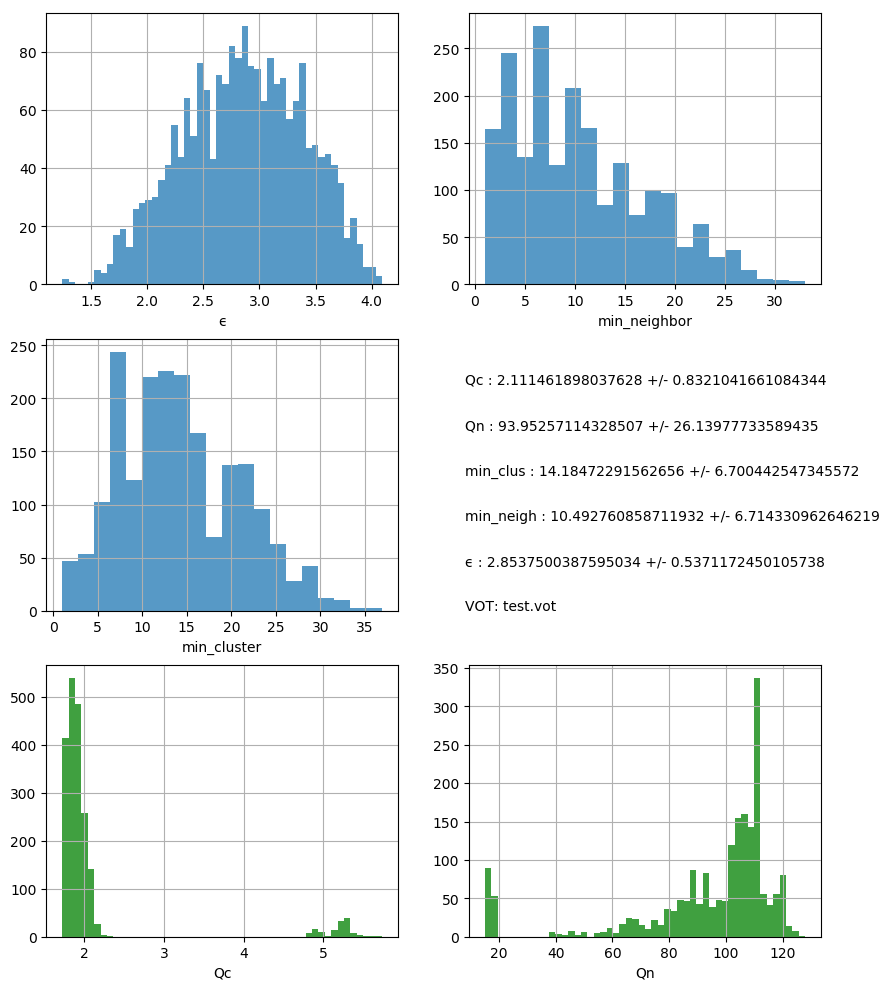

## DBSCAN/MCMC stats:
### ϵ : 2.8537500387595034 +/- 0.5371172450105738
### min_nei  : 10.492760858711932 +/- 6.714330962646219
### min_clus  : 14.18472291562656+/- 6.700442547345572
### Qn  : 93.95257114328507 +/- 26.13977733589435
### Qc  : 2.111461898037628 +/- 0.8321041661084344


In [12]:
### main loop

function main(params::GaiaClustering.abc)
    Random.seed!(1237)
    println("## Main ...")
    
    ## Get the cluster data..
    voname = "test.vot"
    dfnorm , dfcart = getdata(voname)
    
    ## run the mcmc for the dbscan parameters

    println("## MCMC : Q minimum  = ", params.minQ)
    println("## MCMC : N stars minimum = ", params.minstars)
    println("## MCMC : iterations = ", params.niter)
    mc = abc_mcmc_dbscan(dfnorm, dfcart, params)
    
    println("## MCMC done.")
    
    ## plots ################################
    plot_dbscan_mcmc(plotdir, voname, mc, true)
    
    ## Stats
    println("## DBSCAN/MCMC stats:")
    println("### ϵ : ",mean(mc.eps)," +/- ", std(mc.eps))
    println("### min_nei  : ",mean(mc.mne)," +/- ", std(mc.mne))
    println("### min_clus  : ",mean(mc.mcl),"+/- ", std(mc.mcl))
    println("### Qn  : ",mean(mc.qn)," +/- ", std(mc.qn)) 
    println("### Qc  : ",mean(mc.qc)," +/- ", std(mc.qc)) 
        
end

### main 
minQ    = 4.0
minstars = 40
##
epsmean = 2.5
epsdisp = 1.5
min_nei   = 10
min_cl    = 15
ncoredisp = 10
##
nburnout  = 300
niter     = 2000
pinit = GaiaClustering.abc(minQ, minstars, epsmean,epsdisp,min_nei, min_cl, ncoredisp, nburnout , niter)
##
main(pinit)